# Eclipse Lift Curve Generation - Manifold Outlet Pressure Control

This notebook generates Eclipse-compatible VFP lift curves with **manifold outlet pressure control**.

**Key difference from standard approach:**
- Instead of setting compressor outlet pressures directly, we set the **target manifold outlet pressure**
- The compressor outlet pressures are **iterated** to achieve the target manifold pressure
- This accounts for pressure drops in the piping between compressors and manifold

**Operating Envelope:**
- Manifold outlet pressures: 100-130 bara
- Flow rates: 30-70 MSm3/day

## 1. Import Libraries and Setup NeqSim

In [89]:
import neqsim
from neqsim import jneqsim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import brentq, minimize_scalar
import os

# Import Java classes
SystemPrEos = jneqsim.thermo.system.SystemPrEos
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
Splitter = jneqsim.process.equipment.splitter.Splitter
Compressor = jneqsim.process.equipment.compressor.Compressor
CompressorDriver = jneqsim.process.equipment.compressor.CompressorDriver
DriverType = jneqsim.process.equipment.compressor.DriverType
Separator = jneqsim.process.equipment.separator.Separator
ThreePhaseSeparator = jneqsim.process.equipment.separator.ThreePhaseSeparator
PipeBeggsAndBrills = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills
Manifold = jneqsim.process.equipment.manifold.Manifold
StreamSaturatorUtil = jneqsim.process.equipment.util.StreamSaturatorUtil

print("NeqSim imported successfully")

NeqSim imported successfully


## 2. Build the Process Model

In [90]:
def create_process_system(inlet_pressure_bara=37.16, inlet_temp_C=48.5):
    """Create the multi-train gas processing system."""
    
    # Create test fluid with natural gas composition
    test_system = SystemPrEos(298.15, 10.0)
    test_system.addComponent("nitrogen", 0.0015)
    test_system.addComponent("methane", 0.925)
    test_system.addComponent("ethane", 0.03563)
    test_system.addComponent("propane", 0.00693)
    test_system.addComponent("water", 0.001)
    test_system.setMixingRule("classic")
    test_system.setMultiPhaseCheck(True)
    
    process_system = ProcessSystem()
    
    # Create inlet stream
    inlet_stream = Stream("Inlet Stream", test_system)
    inlet_stream.setFlowRate(2000000.0, "kg/hr")
    inlet_stream.setTemperature(inlet_temp_C, "C")
    inlet_stream.setPressure(inlet_pressure_bara, "bara")
    inlet_stream.run()
    process_system.add(inlet_stream)
    
    # Saturate with water
    saturator = StreamSaturatorUtil("Water Saturator", inlet_stream)
    saturator.run()
    process_system.add(saturator)
    
    saturated_stream = Stream("Saturated Stream", saturator.getOutletStream())
    saturated_stream.run()
    process_system.add(saturated_stream)
    
    # Create 4-way splitter for inlet trains
    splitter = Splitter("Test Splitter", saturated_stream)
    splitter.setSplitFactors([0.25, 0.25, 0.25, 0.25])
    splitter.run()
    process_system.add(splitter)
    
    # Create processing trains
    def create_processing_train(train_name, inlet_stream, process_system):
        inlet_pipe = PipeBeggsAndBrills(train_name + " Inlet Pipe", inlet_stream)
        inlet_pipe.setLength(100.0)
        inlet_pipe.setDiameter(0.7)
        inlet_pipe.setPipeWallRoughness(15e-6)
        inlet_pipe.setElevation(0)
        inlet_pipe.run()
        process_system.add(inlet_pipe)
        
        separator = ThreePhaseSeparator(train_name + " Separator", inlet_pipe.getOutletStream())
        separator.run()
        process_system.add(separator)
        
        outlet_pipe = PipeBeggsAndBrills(train_name + " Outlet Pipe", separator.getGasOutStream())
        outlet_pipe.setLength(100.0)
        outlet_pipe.setDiameter(0.7)
        outlet_pipe.setPipeWallRoughness(15e-6)
        outlet_pipe.setElevation(0)
        outlet_pipe.setNumberOfIncrements(10)
        outlet_pipe.run()
        process_system.add(outlet_pipe)
        return outlet_pipe
    
    train1 = create_processing_train("Train1", splitter.getSplitStream(0), process_system)
    train2 = create_processing_train("Train2", splitter.getSplitStream(1), process_system)
    train3 = create_processing_train("Train3", splitter.getSplitStream(2), process_system)
    train4 = create_processing_train("Train4", splitter.getSplitStream(3), process_system)
    
    # Final separator
    final_separator = ThreePhaseSeparator("Final Separator")
    final_separator.addStream(train1.getOutletStream())
    final_separator.addStream(train2.getOutletStream())
    final_separator.addStream(train3.getOutletStream())
    final_separator.addStream(train4.getOutletStream())
    final_separator.setInternalDiameter(3.0)
    final_separator.run()
    process_system.add(final_separator)
    
    # Splitter to 3 compressor trains
    splitter2 = Splitter("Test Splitter2", final_separator.getGasOutStream())
    splitter2.setSplitFactors([1.0/3.0, 1.0/3.0, 1.0/3.0])
    splitter2.run()
    process_system.add(splitter2)
    
    # Create compressor trains
    def create_compressor_train(train_name, inlet_stream, process_system, outlet_pressure):
        inlet_pipe = PipeBeggsAndBrills(train_name + " ups Pipe", inlet_stream)
        inlet_pipe.setLength(100)
        inlet_pipe.setDiameter(0.875)
        inlet_pipe.setPipeWallRoughness(15e-6)
        inlet_pipe.setElevation(0)
        inlet_pipe.run()
        process_system.add(inlet_pipe)
        
        separator = Separator(train_name + " ups Separator", inlet_pipe.getOutletStream())
        separator.run()
        process_system.add(separator)
        
        outlet_pipe = PipeBeggsAndBrills(train_name + " ups Outlet Pipe", separator.getGasOutStream())
        outlet_pipe.setLength(50.0)
        outlet_pipe.setDiameter(0.85)
        outlet_pipe.setPipeWallRoughness(15e-6)
        outlet_pipe.setElevation(0)
        outlet_pipe.run()
        process_system.add(outlet_pipe)
        
        compressor = Compressor(train_name + " Compressor", outlet_pipe.getOutletStream())
        compressor.setOutletPressure(outlet_pressure, "bara")
        compressor.setUsePolytropicCalc(True)
        compressor.setPolytropicEfficiency(0.85)
        compressor.setSpeed(8000)
        compressor.run()
        process_system.add(compressor)
        
        outlet_pipe2 = PipeBeggsAndBrills(train_name + " ups Outlet Pipe2", compressor.getOutletStream())
        outlet_pipe2.setLength(50.0)
        outlet_pipe2.setDiameter(0.85)
        outlet_pipe2.setPipeWallRoughness(15e-6)
        outlet_pipe2.setElevation(0)
        outlet_pipe2.run()
        process_system.add(outlet_pipe2)
        
        return outlet_pipe2.getOutletStream()
    
    ups1 = create_compressor_train("ups1", splitter2.getSplitStream(0), process_system, 110.0)
    ups2 = create_compressor_train("ups2", splitter2.getSplitStream(1), process_system, 110.0)
    ups3 = create_compressor_train("ups3", splitter2.getSplitStream(2), process_system, 110.0)
    
    # Manifold
    manifold = Manifold("Compressor Outlet Manifold")
    manifold.addStream(ups1)
    manifold.addStream(ups2)
    manifold.addStream(ups3)
    manifold.setSplitFactors([1.0/3.0, 1.0/3.0, 1.0/3.0])
    manifold.setHeaderInnerDiameter(1.5)
    manifold.setBranchInnerDiameter(0.6)
    manifold.run()
    process_system.add(manifold)
    
    process_system.run()
    
    return process_system

# Create initial process system
process_system = create_process_system()
print(f"Process system created with {process_system.getUnitOperations().size()} unit operations")

Process system created with 34 unit operations


## 3. Configure Compressor Charts and Drivers

In [91]:
# Configure compressors with charts and drivers
ups1_comp = process_system.getUnit("ups1 Compressor")
ups2_comp = process_system.getUnit("ups2 Compressor")
ups3_comp = process_system.getUnit("ups3 Compressor")
manifold = process_system.getUnit("Compressor Outlet Manifold")

# Load compressor charts
chart_path_1_2 = "C:/Users/ESOL/Documents/GitHub/neqsim2/src/test/resources/compressor_curves/compressor_curve_ups2.json"
chart_path_3 = "C:/Users/ESOL/Documents/GitHub/neqsim2/src/test/resources/compressor_curves/compressor_curve_ups3.json"

for comp, chart_path in [(ups1_comp, chart_path_1_2), (ups2_comp, chart_path_1_2), (ups3_comp, chart_path_3)]:
    comp.loadCompressorChartFromJson(chart_path)
    comp.setSolveSpeed(True)
    # AntiSurge DISABLED - showing theoretical operating points
    comp.getAntiSurge().setActive(False)

# Configure drivers with tabular power curves (speed vs max available power)
speeds_ups1 = [4922.0, 5200.0, 5500.0, 5800.0, 6100.0, 6400.0, 6700.0, 6900.0, 7100.0, 7200.0, 7300.0, 7383.0]
powers_ups1 = [28.0, 30.5, 33.5, 36.5, 39.5, 42.0, 43.8, 44.2, 44.35, 44.38, 44.40, 44.40]  # MW

speeds_ups3 = [4484.0, 4700.0, 4950.0, 5200.0, 5450.0, 5700.0, 5950.0, 6150.0, 6350.0, 6500.0, 6600.0, 6680.0, 6726.0]
powers_ups3 = [30.0, 33.0, 36.5, 40.0, 43.5, 46.5, 48.5, 49.2, 49.6, 49.85, 49.93, 49.98, 50.0]  # MW

# UPS1 driver (44.4 MW max)
driver1 = CompressorDriver(DriverType.VFD_MOTOR, 44400.0)
driver1.setRatedSpeed(7383.0)
driver1.setMaxPowerSpeedCurve(speeds_ups1, powers_ups1, "MW")
ups1_comp.setDriver(driver1)

# UPS2 driver (44.4 MW max)
driver2 = CompressorDriver(DriverType.VFD_MOTOR, 44400.0)
driver2.setRatedSpeed(7383.0)
driver2.setMaxPowerSpeedCurve(speeds_ups1, powers_ups1, "MW")
ups2_comp.setDriver(driver2)

# UPS3 driver (50 MW max)
driver3 = CompressorDriver(DriverType.VFD_MOTOR, 50000.0)
driver3.setRatedSpeed(6726.3)
driver3.setMaxPowerSpeedCurve(speeds_ups3, powers_ups3, "MW")
ups3_comp.setDriver(driver3)

process_system.run()
print("Compressor charts and drivers configured")
print("AntiSurge DISABLED - showing theoretical operating points")
print(f"Initial manifold outlet pressure: {manifold.getSplitStream(0).getPressure('bara'):.2f} bara")

Compressor charts and drivers configured
AntiSurge DISABLED - showing theoretical operating points
Initial manifold outlet pressure: 109.99 bara


## 4. Manifold Pressure Iteration Function

This is the key difference - we iterate compressor outlet pressures to achieve target manifold pressure.

In [92]:
def set_manifold_outlet_pressure(target_manifold_pressure, tolerance=0.1, max_iter=20):
    """Iterate compressor outlet pressures to achieve target manifold outlet pressure.
    
    The manifold has pressure drops from each compressor outlet pipe to the common header.
    We need to set compressor outlet pressures higher than target to compensate.
    
    Args:
        target_manifold_pressure: Target pressure at manifold outlet (bara)
        tolerance: Convergence tolerance (bara)
        max_iter: Maximum iterations
    
    Returns:
        (converged, actual_manifold_pressure, compressor_outlet_pressures)
    """
    # Initial guess: set compressor outlets slightly higher than target
    # Account for ~2-5 bar pressure drop in outlet piping
    initial_comp_pressure = target_manifold_pressure + 3.0
    
    for comp in [ups1_comp, ups2_comp, ups3_comp]:
        comp.setOutletPressure(initial_comp_pressure, "bara")
    
    for iteration in range(max_iter):
        try:
            process_system.run()
        except:
            return False, 0.0, [0.0, 0.0, 0.0]
        
        # Get actual manifold outlet pressure using getSplitStream(0)
        actual_manifold_p = manifold.getSplitStream(0).getPressure("bara")
        error = target_manifold_pressure - actual_manifold_p
        
        if abs(error) < tolerance:
            comp_pressures = [comp.getOutletPressure() for comp in [ups1_comp, ups2_comp, ups3_comp]]
            return True, actual_manifold_p, comp_pressures
        
        # Adjust compressor outlet pressures
        # Increase by error amount (plus small factor for stability)
        adjustment = error * 1.2
        for comp in [ups1_comp, ups2_comp, ups3_comp]:
            new_p = comp.getOutletPressure() + adjustment
            comp.setOutletPressure(new_p, "bara")
    
    # Did not converge
    comp_pressures = [comp.getOutletPressure() for comp in [ups1_comp, ups2_comp, ups3_comp]]
    return False, actual_manifold_p, comp_pressures

# Test the iteration
print("Testing manifold pressure iteration...")
converged, actual_p, comp_p = set_manifold_outlet_pressure(110.0)
print(f"  Target: 110.0 bara")
print(f"  Converged: {converged}")
print(f"  Actual manifold pressure: {actual_p:.2f} bara")
print(f"  Compressor outlet pressures: {[f'{p:.2f}' for p in comp_p]} bara")
print(f"  Pressure drop (comp to manifold): {np.mean(comp_p) - actual_p:.2f} bara")

Testing manifold pressure iteration...
  Target: 110.0 bara
  Converged: True
  Actual manifold pressure: 109.98 bara
  Compressor outlet pressures: ['109.98', '109.98', '109.98'] bara
  Pressure drop (comp to manifold): 0.01 bara


## 5. Define VFP Generation Parameters

In [93]:
# VFP Table Parameters - using MANIFOLD outlet pressure
MANIFOLD_OUTLET_PRESSURES = [100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0]  # bara
FLOW_RATES_MSM3D = [30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0]  # MSm3/day

# Convert MSm3/day to kg/hr
GAS_DENSITY_STD = 0.75  # kg/Sm3

def msm3d_to_kg_hr(msm3_day):
    sm3_day = msm3_day * 1e6
    kg_day = sm3_day * GAS_DENSITY_STD
    return kg_day / 24.0

FLOW_RATES_KG_HR = [msm3d_to_kg_hr(q) for q in FLOW_RATES_MSM3D]

print("VFP Generation Parameters (Manifold Pressure Control):")
print(f"  Manifold outlet pressures: {MANIFOLD_OUTLET_PRESSURES} bara")
print(f"  Flow rates: {FLOW_RATES_MSM3D} MSm3/day")
print(f"  Flow rates: {[f'{q:,.0f}' for q in FLOW_RATES_KG_HR]} kg/hr")

VFP Generation Parameters (Manifold Pressure Control):
  Manifold outlet pressures: [100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0] bara
  Flow rates: [30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0] MSm3/day
  Flow rates: ['937,500', '1,093,750', '1,250,000', '1,406,250', '1,562,500', '1,718,750', '1,875,000', '2,031,250', '2,187,500'] kg/hr


## 6. Utility Functions

In [94]:
from scipy.optimize import minimize
import json

# Load compressor charts for surge checking
def load_compressor_chart(json_path):
    """Load compressor chart data from JSON file."""
    with open(json_path, 'r') as f:
        return json.load(f)

# Load charts once for surge validation
_chart_ups12 = load_compressor_chart(chart_path_1_2)
_chart_ups3 = load_compressor_chart(chart_path_3)

def _extract_surge_line(chart_data):
    """Extract surge line (leftmost points) from chart data."""
    surge_flow = []
    surge_head = []
    for curve in chart_data['speedCurves']:
        surge_flow.append(curve['flow_m3h'][0])
        surge_head.append(curve['head_kJkg'][0])
    return surge_flow, surge_head

_surge_ups12 = _extract_surge_line(_chart_ups12)
_surge_ups3 = _extract_surge_line(_chart_ups3)

def _interpolate_surge_flow(surge_flows, surge_heads, target_head):
    """Interpolate the surge flow at a given head."""
    sorted_pairs = sorted(zip(surge_heads, surge_flows))
    heads_sorted, flows_sorted = zip(*sorted_pairs)
    
    if target_head < min(heads_sorted) or target_head > max(heads_sorted):
        return None
    
    return np.interp(target_head, heads_sorted, flows_sorted)

# Minimum surge margin required for validation/reporting
MIN_SURGE_MARGIN_PCT = 0.0

def check_surge_margin(comp, surge_flows, surge_heads, min_margin_pct=MIN_SURGE_MARGIN_PCT):
    """Check if compressor is operating with adequate surge margin.
    
    Returns: (is_safe, margin_pct)
    """
    try:
        actual_flow = comp.getInletStream().getFlowRate("m3/hr")
        head = comp.getPolytropicFluidHead()
        
        surge_flow = _interpolate_surge_flow(surge_flows, surge_heads, head)
        
        if surge_flow is None:
            return True, 100.0  # Can't check, assume OK
        
        margin_pct = (actual_flow - surge_flow) / surge_flow * 100
        is_safe = margin_pct >= min_margin_pct
        
        return is_safe, margin_pct
    except:
        return True, 100.0  # Error, assume OK

def get_compressor_utilization():
    """Get maximum power utilization across all compressors."""
    max_util = 0.0
    for comp in [ups1_comp, ups2_comp, ups3_comp]:
        driver = comp.getDriver()
        if driver is not None:
            max_power = driver.getMaxAvailablePowerAtSpeed(comp.getSpeed())
            if max_power > 0:
                util = comp.getPower("kW") / max_power
                if util > max_util:
                    max_util = util
    return max_util

def check_compressor_validity(check_surge=True):
    """Check if all compressors are operating within valid range.
    
    Now includes surge margin checking!
    """
    for comp in [ups1_comp, ups2_comp, ups3_comp]:
        if not comp.isSimulationValid():
            return False
        driver = comp.getDriver()
        if driver is not None:
            max_power = driver.getMaxAvailablePowerAtSpeed(comp.getSpeed())
            if max_power > 0 and comp.getPower("kW") > max_power * 1.05:
                return False
    
    # Check surge margins
    if check_surge:
        # UPS1 and UPS2 use the same chart
        for comp in [ups1_comp, ups2_comp]:
            is_safe, margin = check_surge_margin(comp, _surge_ups12[0], _surge_ups12[1])
            if not is_safe:
                return False
        
        # UPS3 uses different chart
        is_safe, margin = check_surge_margin(ups3_comp, _surge_ups3[0], _surge_ups3[1])
        if not is_safe:
            return False
    
    return True

def get_bottleneck_info():
    """Get detailed bottleneck information for all compressors, including map coordinates and surge margin."""
    info = []
    
    compressor_data = [
        ("UPS1", ups1_comp, _surge_ups12),
        ("UPS2", ups2_comp, _surge_ups12),
        ("UPS3", ups3_comp, _surge_ups3)
    ]
    
    for name, comp, surge_data in compressor_data:
        driver = comp.getDriver()
        max_power = driver.getMaxAvailablePowerAtSpeed(comp.getSpeed()) if driver else 0
        power_util = comp.getPower("kW") / max_power if max_power > 0 else 0
        
        # Get compressor map coordinates
        try:
            actual_flow = comp.getInletStream().getFlowRate("m3/hr")
            polytropic_head = comp.getPolytropicFluidHead()
            speed = comp.getSpeed()
        except:
            actual_flow = 0
            polytropic_head = 0
            speed = 0
        
        # Get surge margin
        is_safe, surge_margin = check_surge_margin(comp, surge_data[0], surge_data[1])
        
        info.append({
            'name': name,
            'power_kW': comp.getPower("kW"),
            'max_power_kW': max_power,
            'power_utilization': power_util,
            'speed_rpm': speed,
            'outlet_pressure_bara': comp.getOutletPressure(),
            'is_valid': comp.isSimulationValid(),
            # Compressor map coordinates
            'actual_flow_m3hr': actual_flow,
            'polytropic_head': polytropic_head,
            # Surge margin
            'surge_margin_pct': surge_margin,
            'surge_safe': is_safe,
        })
    return info

print("Utility functions defined WITH SURGE PROTECTION")
print(f"  Minimum surge margin required: {MIN_SURGE_MARGIN_PCT}%")
print(f"  Surge data loaded for UPS1/2 and UPS3 charts")

Utility functions defined WITH SURGE PROTECTION
  Minimum surge margin required: 0.0%
  Surge data loaded for UPS1/2 and UPS3 charts


## 7. Optimize Splits with Manifold Pressure Control

In [95]:
def optimize_splits_for_manifold_pressure(flow_kg_hr, target_manifold_pressure, inlet_pressure):
    """Optimize split factors for a given operating point with manifold pressure control.
    
    Returns: (optimal_splits, max_utilization, is_valid, compressor_outlet_pressures, bottleneck_info)
    """
    inlet_stream = process_system.getUnit("Inlet Stream")
    splitter2 = process_system.getUnit("Test Splitter2")
    
    # Set operating conditions
    inlet_stream.setFlowRate(flow_kg_hr, "kg/hr")
    inlet_stream.setPressure(inlet_pressure, "bara")
    
    def objective(splits):
        """Minimize max utilization (balance load)."""
        s1, s2 = splits
        s3 = 1.0 - s1 - s2
        
        if s3 < 0.15 or s3 > 0.55:
            return 1000.0
        
        splitter2.setSplitFactors([s1, s2, s3])
        
        # Iterate to achieve target manifold pressure
        converged, actual_p, comp_p = set_manifold_outlet_pressure(target_manifold_pressure)
        
        if not converged or not check_compressor_validity():
            return 100.0
        
        return get_compressor_utilization()
    
    # Optimize using Nelder-Mead
    result = minimize(
        objective,
        x0=[0.333, 0.333],
        method='Nelder-Mead',
        options={'maxiter': 50, 'xatol': 0.01, 'fatol': 0.01}
    )
    
    opt_s1, opt_s2 = result.x
    opt_s3 = 1.0 - opt_s1 - opt_s2
    
    # Apply optimal splits and run final iteration
    splitter2.setSplitFactors([opt_s1, opt_s2, opt_s3])
    converged, actual_p, comp_p = set_manifold_outlet_pressure(target_manifold_pressure)
    
    is_valid = converged and check_compressor_validity()
    max_util = get_compressor_utilization()
    bottleneck = get_bottleneck_info()
    
    return [opt_s1, opt_s2, opt_s3], max_util, is_valid, comp_p, bottleneck

print("Split optimization with manifold pressure control defined")

Split optimization with manifold pressure control defined


## 8. Find Minimum Inlet Pressure

In [96]:
def find_minimum_inlet_pressure_manifold(flow_kg_hr, target_manifold_pressure, p_min=25.0, p_max=55.0, tolerance=0.5):
    """Find minimum inlet pressure to achieve target flow at given manifold outlet pressure.
    
    Returns: dict with all results or None if infeasible
    """
    
    def is_feasible(inlet_p):
        splits, util, valid, comp_p, bottleneck = optimize_splits_for_manifold_pressure(
            flow_kg_hr, target_manifold_pressure, inlet_p
        )
        return valid and util < 1.0, splits, util, comp_p, bottleneck
    
    # Adjust p_max based on manifold pressure
    adjusted_p_max = min(p_max, target_manifold_pressure * 0.45)
    adjusted_p_max = max(adjusted_p_max, p_min + 5.0)
    
    # Check if high pressure is feasible
    feasible_high, splits_high, util_high, comp_p_high, bottleneck_high = is_feasible(adjusted_p_max)
    if not feasible_high:
        feasible_high, splits_high, util_high, comp_p_high, bottleneck_high = is_feasible(adjusted_p_max - 5)
        if not feasible_high:
            return None
        adjusted_p_max = adjusted_p_max - 5
    
    # Binary search for minimum pressure
    low, high = p_min, adjusted_p_max
    best_splits = splits_high
    best_util = util_high
    best_comp_p = comp_p_high
    best_bottleneck = bottleneck_high
    
    while high - low > tolerance:
        mid = (low + high) / 2.0
        feasible, splits, util, comp_p, bottleneck = is_feasible(mid)
        
        if feasible:
            high = mid
            best_splits = splits
            best_util = util
            best_comp_p = comp_p
            best_bottleneck = bottleneck
        else:
            low = mid
    
    return {
        'min_inlet_pressure': high,
        'splits': best_splits,
        'max_utilization': best_util,
        'compressor_outlet_pressures': best_comp_p,
        'bottleneck_info': best_bottleneck
    }

print("Minimum inlet pressure search with manifold control defined")

Minimum inlet pressure search with manifold control defined


## 9. Generate VFP Table

In [97]:
# Generate VFP table with manifold pressure control
# Also collect compressor map data for later visualization
vfp_results = []
compressor_map_data = []  # Collect map coordinates during VFP generation

print("Generating VFP Table (Manifold Pressure Control)...")
print("=" * 80)

for p_manifold in MANIFOLD_OUTLET_PRESSURES:
    print(f"\nManifold Outlet Pressure: {p_manifold} bara")
    print("-" * 60)
    
    for i, (flow_msm3d, flow_kg_hr) in enumerate(zip(FLOW_RATES_MSM3D, FLOW_RATES_KG_HR)):
        print(f"  Flow: {flow_msm3d} MSm3/day... ", end="")
        
        result = find_minimum_inlet_pressure_manifold(flow_kg_hr, p_manifold)
        
        if result is not None:
            print(f"Min inlet P: {result['min_inlet_pressure']:.1f} bara, "
                  f"Util: {result['max_utilization']*100:.1f}%, "
                  f"Comp P: {np.mean(result['compressor_outlet_pressures']):.1f} bara")
            
            # Find bottleneck equipment
            bottleneck_eq = max(result['bottleneck_info'], key=lambda x: x['power_utilization'])
            
            vfp_results.append({
                'manifold_pressure_bara': p_manifold,
                'flow_msm3d': flow_msm3d,
                'flow_kg_hr': flow_kg_hr,
                'min_inlet_pressure_bara': result['min_inlet_pressure'],
                'split_1': result['splits'][0],
                'split_2': result['splits'][1],
                'split_3': result['splits'][2],
                'max_utilization': result['max_utilization'],
                'comp_outlet_p_avg': np.mean(result['compressor_outlet_pressures']),
                'comp_outlet_p_1': result['compressor_outlet_pressures'][0],
                'comp_outlet_p_2': result['compressor_outlet_pressures'][1],
                'comp_outlet_p_3': result['compressor_outlet_pressures'][2],
                'bottleneck_equipment': bottleneck_eq['name'],
                'bottleneck_utilization': bottleneck_eq['power_utilization'],
                'feasible': True
            })
            
            # Collect compressor map data for each compressor
            for comp_info in result['bottleneck_info']:
                compressor_map_data.append({
                    'compressor': comp_info['name'],
                    'manifold_pressure_bara': p_manifold,
                    'flow_msm3d': flow_msm3d,
                    'inlet_pressure_bara': result['min_inlet_pressure'],
                    'outlet_pressure_bara': comp_info['outlet_pressure_bara'],
                    'actual_flow_m3hr': comp_info['actual_flow_m3hr'],
                    'polytropic_head': comp_info['polytropic_head'],
                    'speed_rpm': comp_info['speed_rpm'],
                    'power_kW': comp_info['power_kW'],
                    'power_utilization': comp_info['power_utilization']
                })
        else:
            print("INFEASIBLE")
            vfp_results.append({
                'manifold_pressure_bara': p_manifold,
                'flow_msm3d': flow_msm3d,
                'flow_kg_hr': flow_kg_hr,
                'min_inlet_pressure_bara': np.nan,
                'split_1': np.nan,
                'split_2': np.nan,
                'split_3': np.nan,
                'max_utilization': np.nan,
                'comp_outlet_p_avg': np.nan,
                'comp_outlet_p_1': np.nan,
                'comp_outlet_p_2': np.nan,
                'comp_outlet_p_3': np.nan,
                'bottleneck_equipment': 'N/A',
                'bottleneck_utilization': np.nan,
                'feasible': False
            })

vfp_df = pd.DataFrame(vfp_results)
map_df = pd.DataFrame(compressor_map_data)

print("\n" + "=" * 80)
print("VFP Table Generation Complete")
print(f"Collected {len(map_df)} compressor map operating points")

Generating VFP Table (Manifold Pressure Control)...

Manifold Outlet Pressure: 100.0 bara
------------------------------------------------------------
  Flow: 30.0 MSm3/day... INFEASIBLE
  Flow: 35.0 MSm3/day... INFEASIBLE
  Flow: 40.0 MSm3/day... Min inlet P: 30.9 bara, Util: 65.3%, Comp P: 100.0 bara
  Flow: 45.0 MSm3/day... Min inlet P: 30.6 bara, Util: 72.1%, Comp P: 100.0 bara
  Flow: 50.0 MSm3/day... Min inlet P: 31.6 bara, Util: 77.8%, Comp P: 100.0 bara
  Flow: 55.0 MSm3/day... Min inlet P: 32.8 bara, Util: 82.2%, Comp P: 100.0 bara
  Flow: 60.0 MSm3/day... Min inlet P: 33.8 bara, Util: 88.6%, Comp P: 100.0 bara
  Flow: 65.0 MSm3/day... Min inlet P: 35.0 bara, Util: 93.4%, Comp P: 100.0 bara
  Flow: 70.0 MSm3/day... Min inlet P: 36.2 bara, Util: 98.1%, Comp P: 100.0 bara

Manifold Outlet Pressure: 105.0 bara
------------------------------------------------------------
  Flow: 30.0 MSm3/day... INFEASIBLE
  Flow: 35.0 MSm3/day... INFEASIBLE
  Flow: 40.0 MSm3/day... INFEASIBLE
  F

## 10. Display Results

In [98]:
# Display VFP table
print("\n=== VFP LIFT CURVE TABLE (Manifold Pressure Control) ===")
display_cols = ['manifold_pressure_bara', 'flow_msm3d', 'min_inlet_pressure_bara', 
                'comp_outlet_p_avg', 'max_utilization', 'bottleneck_equipment', 'feasible']
print(vfp_df[display_cols].to_string(index=False))

# Pivot table
vfp_pivot = vfp_df.pivot(
    index='flow_msm3d',
    columns='manifold_pressure_bara',
    values='min_inlet_pressure_bara'
)

print("\n=== MINIMUM INLET PRESSURE (bara) ===")
print("Rows: Flow Rate (MSm3/day), Columns: Manifold Outlet Pressure (bara)")
print(vfp_pivot.to_string())


=== VFP LIFT CURVE TABLE (Manifold Pressure Control) ===
 manifold_pressure_bara  flow_msm3d  min_inlet_pressure_bara  comp_outlet_p_avg  max_utilization bottleneck_equipment  feasible
                  100.0        30.0                      NaN                NaN              NaN                  N/A     False
                  100.0        35.0                      NaN                NaN              NaN                  N/A     False
                  100.0        40.0                30.937500          99.978559         0.652737                 UPS2      True
                  100.0        45.0                30.625000          99.979075         0.720614                 UPS1      True
                  100.0        50.0                31.562500          99.979751         0.778060                 UPS1      True
                  100.0        55.0                32.812500          99.980653         0.821510                 UPS1      True
                  100.0        60.0           

## 11. Visualize VFP Curves and Bottlenecks

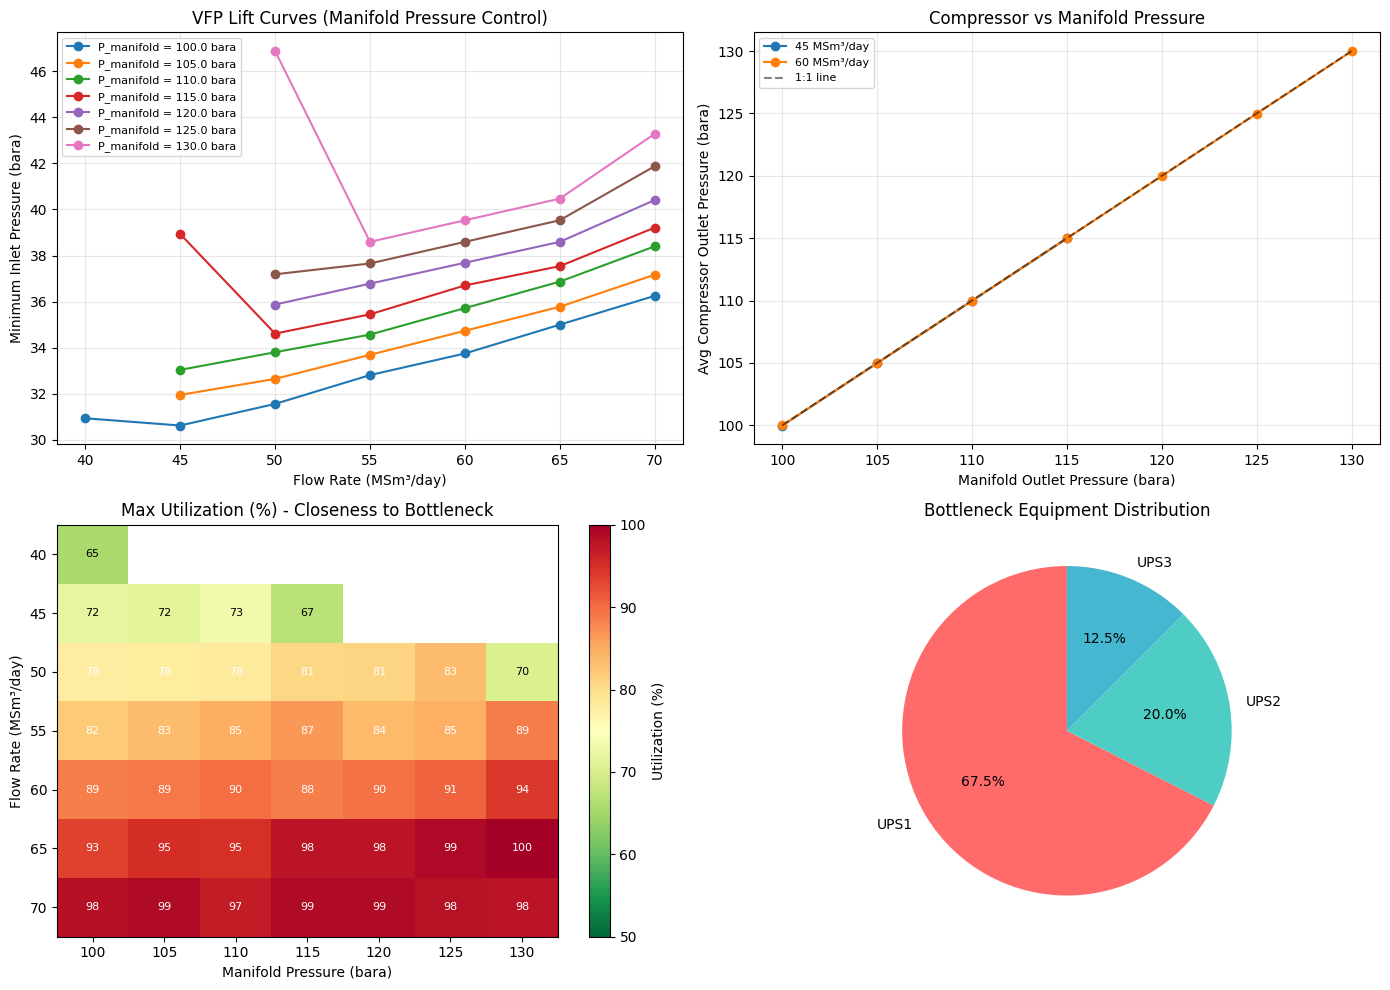

In [99]:
# Plot VFP curves with bottleneck information
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Inlet Pressure vs Flow
ax1 = axes[0, 0]
for p_out in MANIFOLD_OUTLET_PRESSURES:
    subset = vfp_df[(vfp_df['manifold_pressure_bara'] == p_out) & (vfp_df['feasible'])]
    if not subset.empty:
        ax1.plot(subset['flow_msm3d'], subset['min_inlet_pressure_bara'], 
                 'o-', label=f'P_manifold = {p_out} bara', markersize=6)

ax1.set_xlabel('Flow Rate (MSm³/day)')
ax1.set_ylabel('Minimum Inlet Pressure (bara)')
ax1.set_title('VFP Lift Curves (Manifold Pressure Control)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Compressor Outlet vs Manifold Pressure
ax2 = axes[0, 1]
feasible_df = vfp_df[vfp_df['feasible']]
if not feasible_df.empty:
    for flow in [30.0, 45.0, 60.0]:
        subset = feasible_df[feasible_df['flow_msm3d'] == flow]
        if not subset.empty:
            ax2.plot(subset['manifold_pressure_bara'], subset['comp_outlet_p_avg'], 
                     'o-', label=f'{flow:.0f} MSm³/day', markersize=6)
    # Add 1:1 reference line
    ax2.plot([100, 130], [100, 130], 'k--', alpha=0.5, label='1:1 line')

ax2.set_xlabel('Manifold Outlet Pressure (bara)')
ax2.set_ylabel('Avg Compressor Outlet Pressure (bara)')
ax2.set_title('Compressor vs Manifold Pressure')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Utilization Heatmap
ax3 = axes[1, 0]
if not feasible_df.empty:
    pivot_util = feasible_df.pivot(
        index='flow_msm3d',
        columns='manifold_pressure_bara',
        values='max_utilization'
    ) * 100  # Convert to percentage
    
    im = ax3.imshow(pivot_util.values, cmap='RdYlGn_r', aspect='auto', vmin=50, vmax=100)
    ax3.set_xticks(range(len(pivot_util.columns)))
    ax3.set_xticklabels([f'{p:.0f}' for p in pivot_util.columns])
    ax3.set_yticks(range(len(pivot_util.index)))
    ax3.set_yticklabels([f'{q:.0f}' for q in pivot_util.index])
    ax3.set_xlabel('Manifold Pressure (bara)')
    ax3.set_ylabel('Flow Rate (MSm³/day)')
    ax3.set_title('Max Utilization (%) - Closeness to Bottleneck')
    cbar = plt.colorbar(im, ax=ax3)
    cbar.set_label('Utilization (%)')
    
    # Add annotations
    for i in range(len(pivot_util.index)):
        for j in range(len(pivot_util.columns)):
            val = pivot_util.values[i, j]
            if not np.isnan(val):
                color = 'white' if val > 75 else 'black'
                ax3.text(j, i, f'{val:.0f}', ha='center', va='center', color=color, fontsize=8)

# Plot 4: Bottleneck Equipment Distribution
ax4 = axes[1, 1]
if not feasible_df.empty:
    bottleneck_counts = feasible_df['bottleneck_equipment'].value_counts()
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    ax4.pie(bottleneck_counts.values, labels=bottleneck_counts.index, autopct='%1.1f%%',
            colors=colors[:len(bottleneck_counts)], startangle=90)
    ax4.set_title('Bottleneck Equipment Distribution')

plt.tight_layout()
plt.show()

## 12. Bottleneck Analysis Detail

In [100]:
# Detailed bottleneck analysis
print("\n=== BOTTLENECK ANALYSIS ===")
print("\nPoints closest to bottleneck (utilization > 90%):")
print("-" * 80)

high_util = vfp_df[(vfp_df['feasible']) & (vfp_df['max_utilization'] > 0.9)]
if not high_util.empty:
    for _, row in high_util.iterrows():
        print(f"  P_manifold={row['manifold_pressure_bara']:.0f} bara, "
              f"Flow={row['flow_msm3d']:.0f} MSm3/d: "
              f"{row['bottleneck_equipment']} at {row['bottleneck_utilization']*100:.1f}% utilization")
else:
    print("  No points with utilization > 90%")

print("\n\nBottleneck equipment by operating region:")
print("-" * 80)

# Group by manifold pressure
for p_out in MANIFOLD_OUTLET_PRESSURES:
    subset = vfp_df[(vfp_df['manifold_pressure_bara'] == p_out) & (vfp_df['feasible'])]
    if not subset.empty:
        bottleneck_dist = subset['bottleneck_equipment'].value_counts()
        print(f"  P_manifold = {p_out} bara: {dict(bottleneck_dist)}")


=== BOTTLENECK ANALYSIS ===

Points closest to bottleneck (utilization > 90%):
--------------------------------------------------------------------------------
  P_manifold=100 bara, Flow=65 MSm3/d: UPS1 at 93.4% utilization
  P_manifold=100 bara, Flow=70 MSm3/d: UPS1 at 98.1% utilization
  P_manifold=105 bara, Flow=65 MSm3/d: UPS1 at 95.1% utilization
  P_manifold=105 bara, Flow=70 MSm3/d: UPS1 at 98.6% utilization
  P_manifold=110 bara, Flow=65 MSm3/d: UPS1 at 95.1% utilization
  P_manifold=110 bara, Flow=70 MSm3/d: UPS1 at 96.9% utilization
  P_manifold=115 bara, Flow=65 MSm3/d: UPS1 at 97.7% utilization
  P_manifold=115 bara, Flow=70 MSm3/d: UPS3 at 98.8% utilization
  P_manifold=120 bara, Flow=65 MSm3/d: UPS1 at 97.8% utilization
  P_manifold=120 bara, Flow=70 MSm3/d: UPS3 at 98.7% utilization
  P_manifold=125 bara, Flow=60 MSm3/d: UPS2 at 90.8% utilization
  P_manifold=125 bara, Flow=65 MSm3/d: UPS1 at 98.9% utilization
  P_manifold=125 bara, Flow=70 MSm3/d: UPS3 at 98.0% utiliz

## 13. Export Eclipse VFP File

In [101]:
# Generate Eclipse VFP file
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

def generate_eclipse_vfpprod_manifold(vfp_df, table_num=1, datum_depth=0.0):
    """Generate Eclipse VFPPROD with manifold pressure as THP."""
    
    lines = []
    lines.append("-- ============================================================")
    lines.append("-- Eclipse VFPPROD Table - Manifold Pressure Control")
    lines.append(f"-- Generated by NeqSim: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    lines.append("-- THP = Manifold outlet pressure (accounts for piping losses)")
    lines.append("-- BHP = Required inlet pressure to compression system")
    lines.append("-- ============================================================")
    lines.append("")
    lines.append("VFPPROD")
    lines.append("")
    lines.append(f"-- Table  Datum    FLO    WFR    GFR    THP    ALQ    Units")
    lines.append(f"   {table_num}     {datum_depth:.1f}    GAS    WCT    GOR    THP    ''     METRIC /")
    lines.append("")
    
    # Flow rates
    flow_rates = sorted(vfp_df['flow_msm3d'].unique())
    flow_rates_1000sm3 = [q * 1000.0 for q in flow_rates]
    lines.append(f"-- Flow rates (1000 Sm3/day)")
    lines.append("  " + "  ".join([f"{q:.1f}" for q in flow_rates_1000sm3]) + " /")
    lines.append("")
    
    # THP (manifold pressures)
    thp_values = sorted(vfp_df['manifold_pressure_bara'].unique())
    lines.append("-- THP values (barsa) - Manifold outlet pressure")
    lines.append("  " + "  ".join([f"{p:.1f}" for p in thp_values]) + " /")
    lines.append("")
    
    lines.append("-- Water cut fractions")
    lines.append("  0.0 /")
    lines.append("")
    lines.append("-- GOR values")
    lines.append("  999999 /")
    lines.append("")
    lines.append("-- ALQ values")
    lines.append("  0 /")
    lines.append("")
    
    # BHP tables
    lines.append("-- BHP values (barsa) - Required inlet pressure")
    for thp in thp_values:
        lines.append(f"-- THP = {thp:.1f} barsa (Manifold)")
        bhp_values = []
        for q in flow_rates:
            row = vfp_df[(vfp_df['manifold_pressure_bara'] == thp) & (vfp_df['flow_msm3d'] == q)]
            if not row.empty and row['feasible'].values[0]:
                bhp_values.append(f"{row['min_inlet_pressure_bara'].values[0]:.2f}")
            else:
                bhp_values.append("1*")
        lines.append("  " + "  ".join(bhp_values) + " /")
    
    lines.append("")
    lines.append("/")
    lines.append("")
    
    # Summary
    lines.append("-- ============================================================")
    lines.append("-- SUMMARY TABLE")
    lines.append("-- ============================================================")
    header = "-- P_manifold  " + "  ".join([f"{q:>8.0f}" for q in flow_rates]) + "  (MSm3/d)"
    lines.append(header)
    lines.append("-- " + "-" * (len(header) - 3))
    
    for thp in thp_values:
        row_vals = []
        for q in flow_rates:
            row = vfp_df[(vfp_df['manifold_pressure_bara'] == thp) & (vfp_df['flow_msm3d'] == q)]
            if not row.empty and row['feasible'].values[0]:
                row_vals.append(f"{row['min_inlet_pressure_bara'].values[0]:>8.2f}")
            else:
                row_vals.append("     N/A")
        lines.append(f"-- {thp:>8.1f}  " + "  ".join(row_vals))
    
    lines.append("--")
    feasible_count = len(vfp_df[vfp_df['feasible']])
    lines.append(f"-- Feasible points: {feasible_count}/{len(vfp_df)}")
    lines.append("")
    
    return "\n".join(lines)

# Generate and save
eclipse_vfp = generate_eclipse_vfpprod_manifold(vfp_df)
print(eclipse_vfp)

output_file = os.path.join(output_dir, "VFPPROD_manifold_pressure.INC")
with open(output_file, 'w') as f:
    f.write(eclipse_vfp)
print(f"\n{'='*60}")
print(f"Eclipse VFP file saved to: {output_file}")

# Save detailed CSV
csv_file = os.path.join(output_dir, "vfp_manifold_pressure_detailed.csv")
vfp_df.to_csv(csv_file, index=False)
print(f"Detailed results saved to: {csv_file}")

-- ============================================================
-- Eclipse VFPPROD Table - Manifold Pressure Control
-- Generated by NeqSim: 2026-01-25 00:00:44
-- THP = Manifold outlet pressure (accounts for piping losses)
-- BHP = Required inlet pressure to compression system
-- ============================================================

VFPPROD

-- Table  Datum    FLO    WFR    GFR    THP    ALQ    Units
   1     0.0    GAS    WCT    GOR    THP    ''     METRIC /

-- Flow rates (1000 Sm3/day)
  30000.0  35000.0  40000.0  45000.0  50000.0  55000.0  60000.0  65000.0  70000.0 /

-- THP values (barsa) - Manifold outlet pressure
  100.0  105.0  110.0  115.0  120.0  125.0  130.0 /

-- Water cut fractions
  0.0 /

-- GOR values
  999999 /

-- ALQ values
  0 /

-- BHP values (barsa) - Required inlet pressure
-- THP = 100.0 barsa (Manifold)
  1*  1*  30.94  30.62  31.56  32.81  33.75  35.00  36.25 /
-- THP = 105.0 barsa (Manifold)
  1*  1*  1*  31.95  32.65  33.69  34.73  35.78  37.17 /
--

## 14. Operating Envelope Summary

In [102]:
# Operating envelope analysis
feasible_points = vfp_df[vfp_df['feasible']]
infeasible_points = vfp_df[~vfp_df['feasible']]

print("\n=== OPERATING ENVELOPE ANALYSIS (Manifold Pressure Control) ===")
print(f"Total operating points analyzed: {len(vfp_df)}")
print(f"Feasible points: {len(feasible_points)} ({100*len(feasible_points)/len(vfp_df):.1f}%)")
print(f"Infeasible points: {len(infeasible_points)} ({100*len(infeasible_points)/len(vfp_df):.1f}%)")

if not feasible_points.empty:
    print(f"\nInlet Pressure Range:")
    print(f"  Minimum: {feasible_points['min_inlet_pressure_bara'].min():.1f} bara")
    print(f"  Maximum: {feasible_points['min_inlet_pressure_bara'].max():.1f} bara")
    
    print(f"\nCompressor Outlet Pressure Range (to achieve manifold target):")
    print(f"  Minimum avg: {feasible_points['comp_outlet_p_avg'].min():.1f} bara")
    print(f"  Maximum avg: {feasible_points['comp_outlet_p_avg'].max():.1f} bara")
    
    print(f"\nPressure Drop (Compressor to Manifold):")
    pressure_drops = feasible_points['comp_outlet_p_avg'] - feasible_points['manifold_pressure_bara']
    print(f"  Average: {pressure_drops.mean():.2f} bara")
    print(f"  Range: {pressure_drops.min():.2f} - {pressure_drops.max():.2f} bara")
    
    print(f"\nMaximum Flow Rate by Manifold Pressure:")
    for p_out in MANIFOLD_OUTLET_PRESSURES:
        subset = feasible_points[feasible_points['manifold_pressure_bara'] == p_out]
        if not subset.empty:
            max_flow = subset['flow_msm3d'].max()
            row = subset[subset['flow_msm3d'] == max_flow].iloc[0]
            print(f"  P_manifold = {p_out} bara: Max flow = {max_flow:.1f} MSm3/day "
                  f"@ P_in = {row['min_inlet_pressure_bara']:.1f} bara, "
                  f"Bottleneck: {row['bottleneck_equipment']}")


=== OPERATING ENVELOPE ANALYSIS (Manifold Pressure Control) ===
Total operating points analyzed: 63
Feasible points: 40 (63.5%)
Infeasible points: 23 (36.5%)

Inlet Pressure Range:
  Minimum: 30.6 bara
  Maximum: 46.9 bara

Compressor Outlet Pressure Range (to achieve manifold target):
  Minimum avg: 100.0 bara
  Maximum avg: 130.0 bara

Pressure Drop (Compressor to Manifold):
  Average: -0.02 bara
  Range: -0.02 - -0.02 bara

Maximum Flow Rate by Manifold Pressure:
  P_manifold = 100.0 bara: Max flow = 70.0 MSm3/day @ P_in = 36.2 bara, Bottleneck: UPS1
  P_manifold = 105.0 bara: Max flow = 70.0 MSm3/day @ P_in = 37.2 bara, Bottleneck: UPS1
  P_manifold = 110.0 bara: Max flow = 70.0 MSm3/day @ P_in = 38.4 bara, Bottleneck: UPS1
  P_manifold = 115.0 bara: Max flow = 70.0 MSm3/day @ P_in = 39.2 bara, Bottleneck: UPS3
  P_manifold = 120.0 bara: Max flow = 70.0 MSm3/day @ P_in = 40.4 bara, Bottleneck: UPS3
  P_manifold = 125.0 bara: Max flow = 70.0 MSm3/day @ P_in = 41.9 bara, Bottleneck:

## Summary

This notebook generates Eclipse VFP lift curves with **manifold outlet pressure control**:

**Key Features:**
1. **Manifold pressure iteration** - Compressor outlet pressures are iterated to achieve target manifold pressure
2. **Accounts for piping losses** - Pressure drops between compressors and manifold are captured
3. **Split factor optimization** - Load balancing across compressor trains
4. **Bottleneck tracking** - Identifies which compressor is limiting at each operating point

**Output Files:**
- `output/VFPPROD_manifold_pressure.INC` - Eclipse VFP keyword file
- `output/vfp_manifold_pressure_detailed.csv` - Detailed results with compressor pressures

## 15. Compressor Map with Constant Outlet Pressure Lines

Visualize operating points on the compressor performance map using data collected during VFP generation (no additional simulations needed).

In [103]:
# Load compressor chart data from JSON files for full map visualization
import json

def load_compressor_chart(json_path):
    """Load compressor chart data from JSON file."""
    with open(json_path, 'r') as f:
        return json.load(f)

# Load both charts
chart_ups1_2 = load_compressor_chart(chart_path_1_2)
chart_ups3 = load_compressor_chart(chart_path_3)

print(f"Loaded chart: {chart_ups1_2['compressorName']}")
print(f"  Speeds: {[c['speed_rpm'] for c in chart_ups1_2['speedCurves']]} rpm")
print(f"\nLoaded chart: {chart_ups3['compressorName']}")
print(f"  Speeds: {[c['speed_rpm'] for c in chart_ups3['speedCurves']]} rpm")

# Extract surge line (leftmost points at each speed) and stonewall (rightmost points)
def extract_envelope_lines(chart_data):
    """Extract surge line and stonewall line from chart data."""
    surge_flow = []
    surge_head = []
    stonewall_flow = []
    stonewall_head = []
    
    for curve in chart_data['speedCurves']:
        flows = curve['flow_m3h']
        heads = curve['head_kJkg']
        
        # Surge point = minimum flow (leftmost)
        min_idx = 0
        surge_flow.append(flows[min_idx])
        surge_head.append(heads[min_idx])
        
        # Stonewall point = maximum flow (rightmost)
        max_idx = len(flows) - 1
        stonewall_flow.append(flows[max_idx])
        stonewall_head.append(heads[max_idx])
    
    return (surge_flow, surge_head), (stonewall_flow, stonewall_head)

surge_ups12, stonewall_ups12 = extract_envelope_lines(chart_ups1_2)
surge_ups3, stonewall_ups3 = extract_envelope_lines(chart_ups3)

print("\nEnvelope lines extracted for both charts")

Loaded chart: UPS2 Compressor
  Speeds: [7383, 7031, 6328, 5625, 4922] rpm

Loaded chart: UPS3 Compressor
  Speeds: [6726.3, 6406, 6085.7, 5765.4, 5445.1, 5124.8, 4804.5, 4484.2] rpm

Envelope lines extracted for both charts


In [104]:
# Diagnostic: Check chart data ranges vs operating point ranges
print("CHART DATA ANALYSIS - Checking for units/range mismatch")
print("="*70)

print("\nUPS1/UPS2 Chart (from JSON):")
for curve in chart_ups1_2['speedCurves']:
    print(f"  Speed {curve['speed_rpm']:.0f} rpm: Flow {min(curve['flow_m3h']):.0f}-{max(curve['flow_m3h']):.0f} m3/h, "
          f"Head {min(curve['head_kJkg']):.1f}-{max(curve['head_kJkg']):.1f} kJ/kg")

print("\nUPS3 Chart (from JSON):")
for curve in chart_ups3['speedCurves']:
    print(f"  Speed {curve['speed_rpm']:.0f} rpm: Flow {min(curve['flow_m3h']):.0f}-{max(curve['flow_m3h']):.0f} m3/h, "
          f"Head {min(curve['head_kJkg']):.1f}-{max(curve['head_kJkg']):.1f} kJ/kg")

print("\n" + "="*70)
print("OPERATING POINT DATA (from simulation):")
print("="*70)

for comp in ['UPS1', 'UPS2', 'UPS3']:
    comp_data = map_df[map_df['compressor'] == comp]
    if not comp_data.empty:
        print(f"\n{comp} Operating Points:")
        print(f"  Flow range: {comp_data['actual_flow_m3hr'].min():.0f} - {comp_data['actual_flow_m3hr'].max():.0f} m³/hr")
        print(f"  Head range: {comp_data['polytropic_head'].min():.1f} - {comp_data['polytropic_head'].max():.1f} (units?)")
        print(f"  Speed range: {comp_data['speed_rpm'].min():.0f} - {comp_data['speed_rpm'].max():.0f} rpm")

# Check if head needs unit conversion (kJ/kg vs J/kg vs m)
print("\n" + "="*70)
print("POTENTIAL ISSUE: Check head units from NeqSim")
print("="*70)

# Get current compressor state
ups1_head = ups1_comp.getPolytropicFluidHead()
ups1_head_m = ups1_comp.getPolytropicHead()  # This might be in meters
print(f"ups1_comp.getPolytropicFluidHead() = {ups1_head:.2f}")
print(f"ups1_comp.getPolytropicHead() = {ups1_head_m:.2f}")

# Chart expects kJ/kg, let's see what makes sense
# 1 kJ/kg = 1000 J/kg
# Head in meters * g ≈ Head in J/kg, so 100m * 9.81 = 981 J/kg ≈ 1 kJ/kg
if ups1_head > 1000:
    print(f"\n⚠️  Head value {ups1_head:.0f} suggests units are J/kg, not kJ/kg!")
    print(f"   Try dividing by 1000 to convert to kJ/kg: {ups1_head/1000:.1f} kJ/kg")

CHART DATA ANALYSIS - Checking for units/range mismatch

UPS1/UPS2 Chart (from JSON):
  Speed 7383 rpm: Flow 22025-35565 m3/h, Head 138.4-215.4 kJ/kg
  Speed 7031 rpm: Flow 19671-33406 m3/h, Head 125.5-196.4 kJ/kg
  Speed 6328 rpm: Flow 15662-29314 m3/h, Head 100.1-160.6 kJ/kg
  Speed 5625 rpm: Flow 13588-25053 m3/h, Head 81.4-126.5 kJ/kg
  Speed 4922 rpm: Flow 11962-20708 m3/h, Head 64.8-95.6 kJ/kg

UPS3 Chart (from JSON):
  Speed 6726 rpm: Flow 22376-38991 m3/h, Head 113.7-257.6 kJ/kg
  Speed 6406 rpm: Flow 20519-36619 m3/h, Head 108.5-233.4 kJ/kg
  Speed 6086 rpm: Flow 18682-34266 m3/h, Head 99.3-210.5 kJ/kg
  Speed 5765 rpm: Flow 17120-31844 m3/h, Head 91.6-188.3 kJ/kg
  Speed 5445 rpm: Flow 15572-29344 m3/h, Head 84.4-167.4 kJ/kg
  Speed 5125 rpm: Flow 14149-26802 m3/h, Head 77.2-147.6 kJ/kg
  Speed 4804 rpm: Flow 12816-24300 m3/h, Head 69.6-129.0 kJ/kg
  Speed 4484 rpm: Flow 11582-21882 m3/h, Head 62.0-111.6 kJ/kg

OPERATING POINT DATA (from simulation):

UPS1 Operating Points:
 

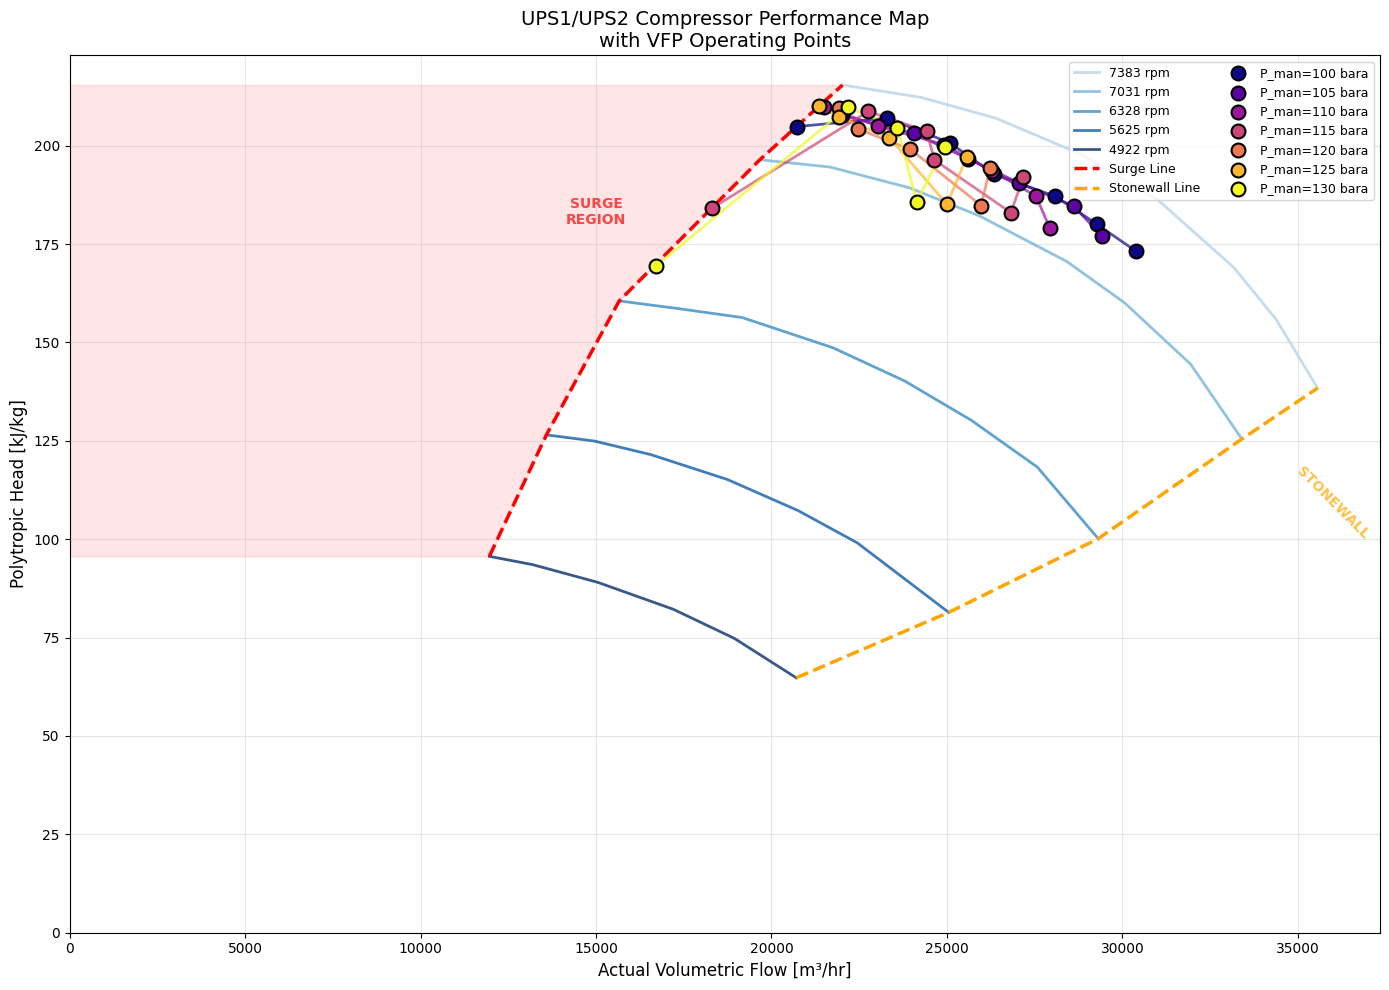

In [105]:
# Plot full compressor map for UPS1/UPS2 with operating points overlay
fig, ax = plt.subplots(figsize=(14, 10))

# Plot speed curves from chart
cmap_speeds = plt.cm.Blues
n_speeds = len(chart_ups1_2['speedCurves'])

for i, curve in enumerate(chart_ups1_2['speedCurves']):
    color = cmap_speeds(0.3 + 0.7 * i / (n_speeds - 1))
    ax.plot(curve['flow_m3h'], curve['head_kJkg'], 
           '-', color=color, linewidth=2, alpha=0.8,
           label=f"{curve['speed_rpm']:.0f} rpm")

# Plot surge line (red dashed)
surge_flow_sorted = sorted(zip(surge_ups12[0], surge_ups12[1]), key=lambda x: x[1])
surge_f, surge_h = zip(*surge_flow_sorted)
ax.plot(surge_f, surge_h, 'r--', linewidth=2.5, label='Surge Line', zorder=10)
ax.fill_betweenx(surge_h, 0, surge_f, color='red', alpha=0.1)

# Plot stonewall line (orange dashed)
stonewall_sorted = sorted(zip(stonewall_ups12[0], stonewall_ups12[1]), key=lambda x: x[1])
stonewall_f, stonewall_h = zip(*stonewall_sorted)
ax.plot(stonewall_f, stonewall_h, '--', color='orange', linewidth=2.5, label='Stonewall Line', zorder=10)

# Overlay operating points from VFP generation - colored by manifold pressure
ups1_map = map_df[map_df['compressor'] == 'UPS1'].copy()

if not ups1_map.empty:
    cmap_op = plt.cm.plasma
    manifold_pressures = sorted(ups1_map['manifold_pressure_bara'].unique())
    
    for p_manifold in manifold_pressures:
        subset = ups1_map[ups1_map['manifold_pressure_bara'] == p_manifold]
        color_idx = (p_manifold - min(manifold_pressures)) / (max(manifold_pressures) - min(manifold_pressures))
        color = cmap_op(color_idx)
        
        ax.scatter(subset['actual_flow_m3hr'], subset['polytropic_head'],
                  c=[color], s=100, marker='o', edgecolors='black', linewidth=1.5,
                  label=f'P_man={p_manifold:.0f} bara', zorder=15)
        
        # Connect operating points at same manifold pressure
        subset_sorted = subset.sort_values('actual_flow_m3hr')
        ax.plot(subset_sorted['actual_flow_m3hr'], subset_sorted['polytropic_head'],
               '-', color=color, linewidth=2, alpha=0.7, zorder=14)

ax.set_xlabel('Actual Volumetric Flow [m³/hr]', fontsize=12)
ax.set_ylabel('Polytropic Head [kJ/kg]', fontsize=12)
ax.set_title('UPS1/UPS2 Compressor Performance Map\nwith VFP Operating Points', fontsize=14)
ax.legend(loc='upper right', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Add annotations
ax.annotate('SURGE\nREGION', xy=(15000, 180), fontsize=10, color='red', 
           ha='center', fontweight='bold', alpha=0.7)
ax.annotate('STONEWALL', xy=(36000, 100), fontsize=10, color='orange', 
           ha='center', fontweight='bold', alpha=0.7, rotation=-45)

plt.tight_layout()
plt.show()

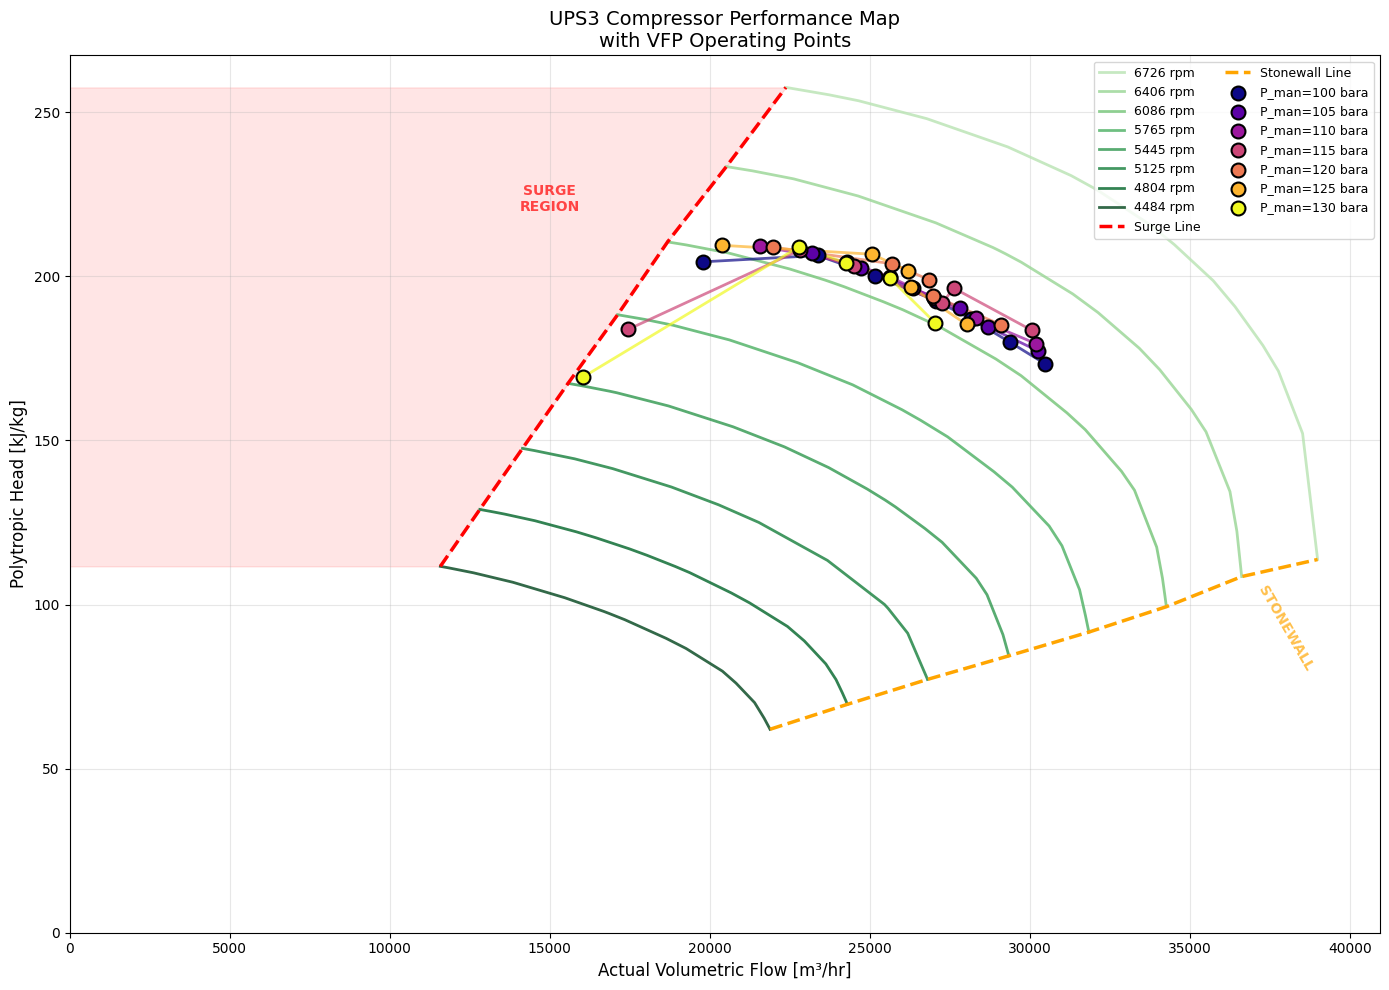

In [106]:
# Plot full compressor map for UPS3 with operating points overlay
fig, ax = plt.subplots(figsize=(14, 10))

# Plot speed curves from chart
cmap_speeds = plt.cm.Greens
n_speeds = len(chart_ups3['speedCurves'])

for i, curve in enumerate(chart_ups3['speedCurves']):
    color = cmap_speeds(0.3 + 0.7 * i / (n_speeds - 1))
    ax.plot(curve['flow_m3h'], curve['head_kJkg'], 
           '-', color=color, linewidth=2, alpha=0.8,
           label=f"{curve['speed_rpm']:.0f} rpm")

# Plot surge line (red dashed)
surge_flow_sorted = sorted(zip(surge_ups3[0], surge_ups3[1]), key=lambda x: x[1])
surge_f, surge_h = zip(*surge_flow_sorted)
ax.plot(surge_f, surge_h, 'r--', linewidth=2.5, label='Surge Line', zorder=10)
ax.fill_betweenx(surge_h, 0, surge_f, color='red', alpha=0.1)

# Plot stonewall line (orange dashed)
stonewall_sorted = sorted(zip(stonewall_ups3[0], stonewall_ups3[1]), key=lambda x: x[1])
stonewall_f, stonewall_h = zip(*stonewall_sorted)
ax.plot(stonewall_f, stonewall_h, '--', color='orange', linewidth=2.5, label='Stonewall Line', zorder=10)

# Overlay operating points from VFP generation
ups3_map = map_df[map_df['compressor'] == 'UPS3'].copy()

if not ups3_map.empty:
    cmap_op = plt.cm.plasma
    manifold_pressures = sorted(ups3_map['manifold_pressure_bara'].unique())
    
    for p_manifold in manifold_pressures:
        subset = ups3_map[ups3_map['manifold_pressure_bara'] == p_manifold]
        color_idx = (p_manifold - min(manifold_pressures)) / (max(manifold_pressures) - min(manifold_pressures))
        color = cmap_op(color_idx)
        
        ax.scatter(subset['actual_flow_m3hr'], subset['polytropic_head'],
                  c=[color], s=100, marker='o', edgecolors='black', linewidth=1.5,
                  label=f'P_man={p_manifold:.0f} bara', zorder=15)
        
        # Connect operating points
        subset_sorted = subset.sort_values('actual_flow_m3hr')
        ax.plot(subset_sorted['actual_flow_m3hr'], subset_sorted['polytropic_head'],
               '-', color=color, linewidth=2, alpha=0.7, zorder=14)

ax.set_xlabel('Actual Volumetric Flow [m³/hr]', fontsize=12)
ax.set_ylabel('Polytropic Head [kJ/kg]', fontsize=12)
ax.set_title('UPS3 Compressor Performance Map\nwith VFP Operating Points', fontsize=14)
ax.legend(loc='upper right', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Add annotations
ax.annotate('SURGE\nREGION', xy=(15000, 220), fontsize=10, color='red', 
           ha='center', fontweight='bold', alpha=0.7)
ax.annotate('STONEWALL', xy=(38000, 80), fontsize=10, color='orange', 
           ha='center', fontweight='bold', alpha=0.7, rotation=-60)

plt.tight_layout()
plt.show()

C:\Users\ESOL\AppData\Local\Temp\ipykernel_1364\2725152220.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


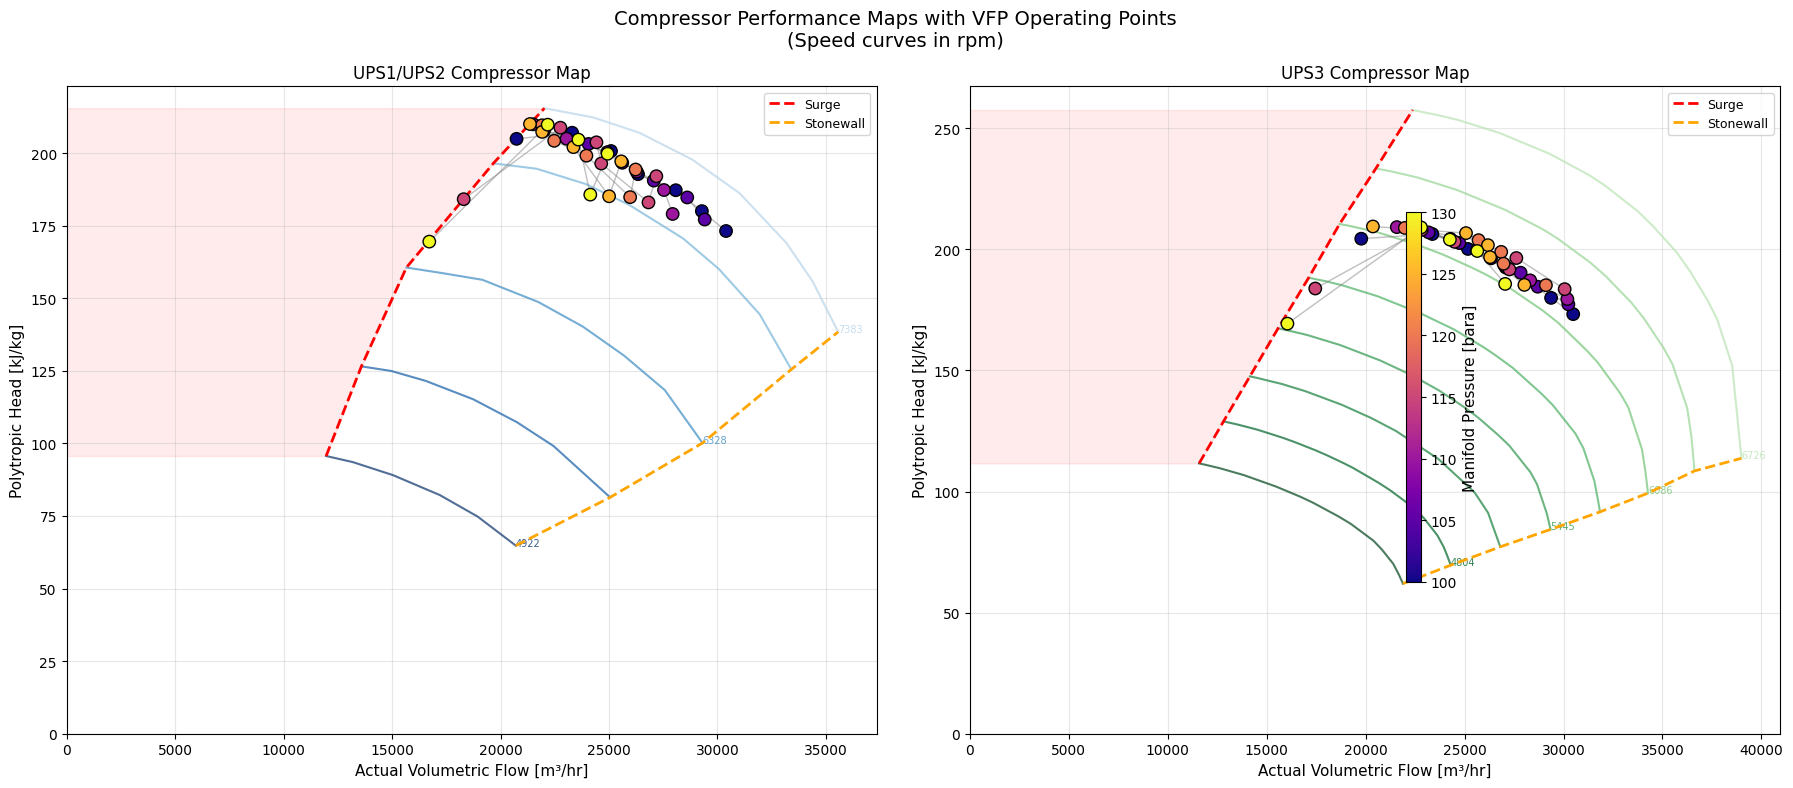


COMPRESSOR OPERATING POINT ANALYSIS

UPS1:
  Actual flow range: 16,718 - 30,398 m³/hr
  Head range: 169.5 - 210.0 kJ/kg
  Speed range: 6,532 - 7,376 rpm
  Power range: 28.7 - 44.4 MW

UPS2:
  Actual flow range: 16,743 - 30,398 m³/hr
  Head range: 169.5 - 210.0 kJ/kg
  Speed range: 6,533 - 7,376 rpm
  Power range: 29.0 - 44.1 MW

UPS3:
  Actual flow range: 16,045 - 30,489 m³/hr
  Head range: 169.3 - 209.5 kJ/kg
  Speed range: 5,507 - 6,445 rpm
  Power range: 26.9 - 49.2 MW


In [107]:
# Side-by-side comparison of both compressor maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

charts = [chart_ups1_2, chart_ups3]
surge_lines = [surge_ups12, surge_ups3]
stonewall_lines = [stonewall_ups12, stonewall_ups3]
comp_names = ['UPS1/UPS2', 'UPS3']
comp_filters = ['UPS1', 'UPS3']
colormaps = [plt.cm.Blues, plt.cm.Greens]

for ax, chart, surge, stonewall, name, comp_filter, cmap_speed in zip(
    axes, charts, surge_lines, stonewall_lines, comp_names, comp_filters, colormaps):
    
    # Plot speed curves
    n_speeds = len(chart['speedCurves'])
    for i, curve in enumerate(chart['speedCurves']):
        color = cmap_speed(0.3 + 0.7 * i / (n_speeds - 1))
        ax.plot(curve['flow_m3h'], curve['head_kJkg'], 
               '-', color=color, linewidth=1.5, alpha=0.7)
        # Add speed label at end of curve
        if i % 2 == 0:  # Label every other curve
            ax.annotate(f"{curve['speed_rpm']:.0f}", 
                       (curve['flow_m3h'][-1], curve['head_kJkg'][-1]),
                       fontsize=7, color=color, alpha=0.8)
    
    # Surge line
    surge_sorted = sorted(zip(surge[0], surge[1]), key=lambda x: x[1])
    surge_f, surge_h = zip(*surge_sorted)
    ax.plot(surge_f, surge_h, 'r--', linewidth=2, label='Surge', zorder=10)
    ax.fill_betweenx(surge_h, 0, surge_f, color='red', alpha=0.08)
    
    # Stonewall line
    stonewall_sorted = sorted(zip(stonewall[0], stonewall[1]), key=lambda x: x[1])
    stonewall_f, stonewall_h = zip(*stonewall_sorted)
    ax.plot(stonewall_f, stonewall_h, '--', color='orange', linewidth=2, label='Stonewall', zorder=10)
    
    # Operating points
    comp_map = map_df[map_df['compressor'] == comp_filter].copy()
    if not comp_map.empty:
        scatter = ax.scatter(comp_map['actual_flow_m3hr'], comp_map['polytropic_head'],
                           c=comp_map['manifold_pressure_bara'], cmap='plasma',
                           s=80, edgecolors='black', linewidth=1, zorder=15,
                           vmin=100, vmax=130)
        
        # Connect by manifold pressure
        for p_man in sorted(comp_map['manifold_pressure_bara'].unique()):
            subset = comp_map[comp_map['manifold_pressure_bara'] == p_man].sort_values('actual_flow_m3hr')
            ax.plot(subset['actual_flow_m3hr'], subset['polytropic_head'],
                   '-', color='gray', linewidth=1, alpha=0.5, zorder=14)
    
    ax.set_xlabel('Actual Volumetric Flow [m³/hr]', fontsize=11)
    ax.set_ylabel('Polytropic Head [kJ/kg]', fontsize=11)
    ax.set_title(f'{name} Compressor Map', fontsize=12)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

# Colorbar for operating points
cbar = fig.colorbar(scatter, ax=axes, shrink=0.6, aspect=25, pad=0.02)
cbar.set_label('Manifold Pressure [bara]', fontsize=11)

plt.suptitle('Compressor Performance Maps with VFP Operating Points\n(Speed curves in rpm)', fontsize=14)
plt.tight_layout()
plt.show()

# Operating point statistics
print("\n" + "="*70)
print("COMPRESSOR OPERATING POINT ANALYSIS")
print("="*70)

for comp in ['UPS1', 'UPS2', 'UPS3']:
    comp_data = map_df[map_df['compressor'] == comp]
    if not comp_data.empty:
        print(f"\n{comp}:")
        print(f"  Actual flow range: {comp_data['actual_flow_m3hr'].min():,.0f} - {comp_data['actual_flow_m3hr'].max():,.0f} m³/hr")
        print(f"  Head range: {comp_data['polytropic_head'].min():.1f} - {comp_data['polytropic_head'].max():.1f} kJ/kg")
        print(f"  Speed range: {comp_data['speed_rpm'].min():,.0f} - {comp_data['speed_rpm'].max():,.0f} rpm")
        print(f"  Power range: {comp_data['power_kW'].min()/1000:.1f} - {comp_data['power_kW'].max()/1000:.1f} MW")

## 16. Compressor Power Analysis

C:\Users\ESOL\AppData\Local\Temp\ipykernel_1364\2239279732.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


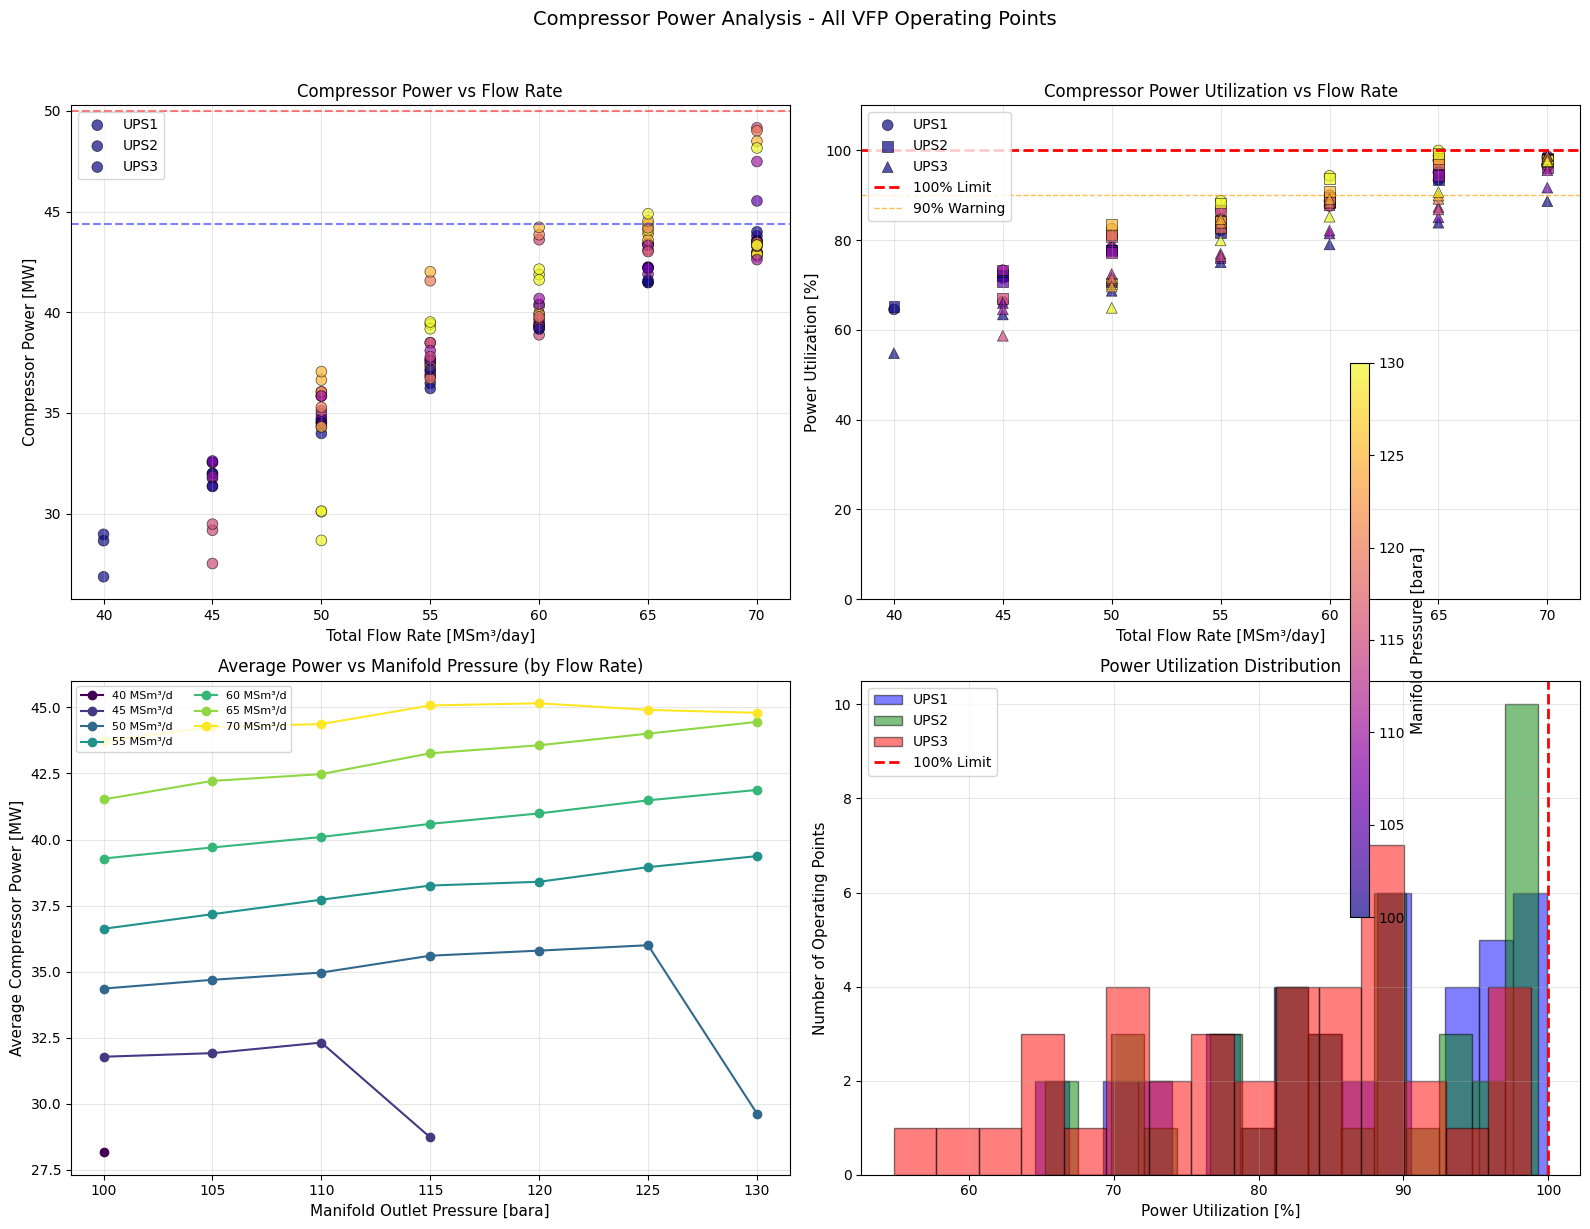


COMPRESSOR POWER SUMMARY

UPS1:
  Power range: 28.7 - 44.4 MW
  Utilization range: 64.6% - 99.9%
  Average utilization: 86.9%
  Points > 95% utilization: 13 (32%)

UPS2:
  Power range: 29.0 - 44.1 MW
  Utilization range: 65.3% - 99.3%
  Average utilization: 86.8%
  Points > 95% utilization: 12 (30%)

UPS3:
  Power range: 26.9 - 49.2 MW
  Utilization range: 54.8% - 98.8%
  Average utilization: 80.6%
  Points > 95% utilization: 5 (12%)


In [108]:
# Compressor Power Analysis - Power and % Utilization for all operating points
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Power vs Flow for each compressor
ax1 = axes[0, 0]
for comp_name, color in [('UPS1', 'blue'), ('UPS2', 'green'), ('UPS3', 'red')]:
    comp_data = map_df[map_df['compressor'] == comp_name]
    if not comp_data.empty:
        scatter = ax1.scatter(comp_data['flow_msm3d'], comp_data['power_kW']/1000, 
                             c=comp_data['manifold_pressure_bara'], cmap='plasma',
                             s=60, alpha=0.7, label=comp_name, edgecolors='black', linewidth=0.5,
                             vmin=100, vmax=130)
ax1.set_xlabel('Total Flow Rate [MSm³/day]', fontsize=11)
ax1.set_ylabel('Compressor Power [MW]', fontsize=11)
ax1.set_title('Compressor Power vs Flow Rate', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=44.4, color='blue', linestyle='--', alpha=0.5, label='UPS1/2 Max')
ax1.axhline(y=50.0, color='red', linestyle='--', alpha=0.5, label='UPS3 Max')

# Plot 2: Power Utilization vs Flow for each compressor
ax2 = axes[0, 1]
for comp_name, marker in [('UPS1', 'o'), ('UPS2', 's'), ('UPS3', '^')]:
    comp_data = map_df[map_df['compressor'] == comp_name]
    if not comp_data.empty:
        scatter = ax2.scatter(comp_data['flow_msm3d'], comp_data['power_utilization']*100, 
                             c=comp_data['manifold_pressure_bara'], cmap='plasma',
                             s=60, alpha=0.7, marker=marker, label=comp_name, 
                             edgecolors='black', linewidth=0.5, vmin=100, vmax=130)
ax2.set_xlabel('Total Flow Rate [MSm³/day]', fontsize=11)
ax2.set_ylabel('Power Utilization [%]', fontsize=11)
ax2.set_title('Compressor Power Utilization vs Flow Rate', fontsize=12)
ax2.axhline(y=100, color='red', linestyle='--', linewidth=2, label='100% Limit')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='90% Warning')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 110)

# Plot 3: Power vs Manifold Pressure (grouped by flow)
ax3 = axes[1, 0]
flow_colors = plt.cm.viridis(np.linspace(0, 1, len(map_df['flow_msm3d'].unique())))
for i, flow in enumerate(sorted(map_df['flow_msm3d'].unique())):
    flow_data = map_df[map_df['flow_msm3d'] == flow]
    # Average power across compressors for each manifold pressure
    avg_power = flow_data.groupby('manifold_pressure_bara')['power_kW'].mean() / 1000
    ax3.plot(avg_power.index, avg_power.values, 'o-', color=flow_colors[i], 
             label=f'{flow:.0f} MSm³/d', markersize=6)
ax3.set_xlabel('Manifold Outlet Pressure [bara]', fontsize=11)
ax3.set_ylabel('Average Compressor Power [MW]', fontsize=11)
ax3.set_title('Average Power vs Manifold Pressure (by Flow Rate)', fontsize=12)
ax3.legend(loc='upper left', fontsize=8, ncol=2)
ax3.grid(True, alpha=0.3)

# Plot 4: Power Utilization Distribution (histogram)
ax4 = axes[1, 1]
for comp_name, color in [('UPS1', 'blue'), ('UPS2', 'green'), ('UPS3', 'red')]:
    comp_data = map_df[map_df['compressor'] == comp_name]
    if not comp_data.empty:
        ax4.hist(comp_data['power_utilization']*100, bins=15, alpha=0.5, 
                label=comp_name, color=color, edgecolor='black')
ax4.set_xlabel('Power Utilization [%]', fontsize=11)
ax4.set_ylabel('Number of Operating Points', fontsize=11)
ax4.set_title('Power Utilization Distribution', fontsize=12)
ax4.axvline(x=100, color='red', linestyle='--', linewidth=2, label='100% Limit')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

# Add colorbar for manifold pressure
cbar = fig.colorbar(scatter, ax=axes[:, 1], shrink=0.6, aspect=30, pad=0.02)
cbar.set_label('Manifold Pressure [bara]', fontsize=11)

plt.suptitle('Compressor Power Analysis - All VFP Operating Points', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("COMPRESSOR POWER SUMMARY")
print("="*70)

for comp_name in ['UPS1', 'UPS2', 'UPS3']:
    comp_data = map_df[map_df['compressor'] == comp_name]
    if not comp_data.empty:
        print(f"\n{comp_name}:")
        print(f"  Power range: {comp_data['power_kW'].min()/1000:.1f} - {comp_data['power_kW'].max()/1000:.1f} MW")
        print(f"  Utilization range: {comp_data['power_utilization'].min()*100:.1f}% - {comp_data['power_utilization'].max()*100:.1f}%")
        print(f"  Average utilization: {comp_data['power_utilization'].mean()*100:.1f}%")
        high_util = len(comp_data[comp_data['power_utilization'] > 0.95])
        print(f"  Points > 95% utilization: {high_util} ({100*high_util/len(comp_data):.0f}%)")

In [109]:
# Debug: Check if compressor data is actually different between UPS1, UPS2, UPS3
print("DIAGNOSTIC: Checking compressor operating point data")
print("="*70)

for comp in ['UPS1', 'UPS2', 'UPS3']:
    comp_data = map_df[map_df['compressor'] == comp]
    print(f"\n{comp}: {len(comp_data)} data points")
    if not comp_data.empty:
        # Show first few points
        print(comp_data[['manifold_pressure_bara', 'flow_msm3d', 'actual_flow_m3hr', 'polytropic_head', 'speed_rpm']].head(5).to_string())

# Check if UPS1 and UPS3 have same values
ups1_data = map_df[map_df['compressor'] == 'UPS1'][['actual_flow_m3hr', 'polytropic_head']].values
ups3_data = map_df[map_df['compressor'] == 'UPS3'][['actual_flow_m3hr', 'polytropic_head']].values

print("\n" + "="*70)
print("Are UPS1 and UPS3 data identical?", np.allclose(ups1_data, ups3_data, rtol=0.01) if len(ups1_data) == len(ups3_data) else "Different lengths")
print(f"UPS1 flow range: {ups1_data[:,0].min():.0f} - {ups1_data[:,0].max():.0f}")
print(f"UPS3 flow range: {ups3_data[:,0].min():.0f} - {ups3_data[:,0].max():.0f}")
print(f"UPS1 head range: {ups1_data[:,1].min():.1f} - {ups1_data[:,1].max():.1f}")
print(f"UPS3 head range: {ups3_data[:,1].min():.1f} - {ups3_data[:,1].max():.1f}")

DIAGNOSTIC: Checking compressor operating point data

UPS1: 40 data points
    manifold_pressure_bara  flow_msm3d  actual_flow_m3hr  polytropic_head    speed_rpm
0                    100.0        40.0      20740.599583       204.875812  7238.267559
3                    100.0        45.0      23302.978530       206.981140  7370.687624
6                    100.0        50.0      25093.498435       200.688446  7368.112075
9                    100.0        55.0      26339.779452       192.709916  7326.736936
12                   100.0        60.0      28079.740459       187.183317  7368.077818

UPS2: 40 data points
    manifold_pressure_bara  flow_msm3d  actual_flow_m3hr  polytropic_head    speed_rpm
1                    100.0        40.0      20996.926780       204.847227  7246.095065
4                    100.0        45.0      23302.978530       206.981140  7370.687624
7                    100.0        50.0      25093.498435       200.688446  7368.112075
10                   100.0       

In [110]:
# Analyze surge margin for operating points
# Check if any points fall in or near the surge region

def interpolate_surge_flow(surge_flows, surge_heads, target_head):
    """Interpolate the surge flow at a given head."""
    # Sort by head for interpolation
    sorted_pairs = sorted(zip(surge_heads, surge_flows))
    heads_sorted, flows_sorted = zip(*sorted_pairs)
    
    if target_head < min(heads_sorted) or target_head > max(heads_sorted):
        return None  # Outside interpolation range
    
    return np.interp(target_head, heads_sorted, flows_sorted)

print("="*70)
print("SURGE MARGIN ANALYSIS")
print("="*70)

# Analyze UPS3 (the one with potential surge issues from the plot)
ups3_map = map_df[map_df['compressor'] == 'UPS3'].copy()

if not ups3_map.empty:
    print("\nUPS3 Operating Points - Surge Analysis:")
    print("-"*70)
    print(f"{'P_man':>6} {'Flow':>10} {'Q_act':>10} {'Head':>8} {'Q_surge':>10} {'Margin':>8} {'Valid?':>6}")
    print(f"{'(bara)':>6} {'(MSm3/d)':>10} {'(m3/hr)':>10} {'(kJ/kg)':>8} {'(m3/hr)':>10} {'(%)':>8} {'':>6}")
    print("-"*70)
    
    surge_violations = []
    
    for _, row in ups3_map.iterrows():
        actual_flow = row['actual_flow_m3hr']
        head = row['polytropic_head']
        
        # Get surge flow at this head
        surge_flow = interpolate_surge_flow(surge_ups3[0], surge_ups3[1], head)
        
        if surge_flow is not None:
            margin_pct = (actual_flow - surge_flow) / surge_flow * 100
            is_valid = actual_flow > surge_flow
            
            # Print with color indicator
            status = "YES" if is_valid else "NO!"
            
            if margin_pct < 10:  # Low margin or in surge
                print(f"{row['manifold_pressure_bara']:>6.0f} {row['flow_msm3d']:>10.0f} {actual_flow:>10.0f} {head:>8.1f} {surge_flow:>10.0f} {margin_pct:>8.1f} {status:>6}")
                
                if not is_valid:
                    surge_violations.append({
                        'manifold_pressure': row['manifold_pressure_bara'],
                        'flow_msm3d': row['flow_msm3d'],
                        'actual_flow': actual_flow,
                        'surge_flow': surge_flow,
                        'margin_pct': margin_pct,
                        'head': head
                    })
    
    print("-"*70)
    
    if surge_violations:
        print(f"\n⚠️  WARNING: {len(surge_violations)} operating points are IN THE SURGE REGION!")
        print("\nSurge violations:")
        for v in surge_violations:
            print(f"  P_man={v['manifold_pressure']:.0f} bara, Flow={v['flow_msm3d']:.0f} MSm3/d: "
                  f"Q_actual={v['actual_flow']:.0f} m3/hr < Q_surge={v['surge_flow']:.0f} m3/hr "
                  f"(margin={v['margin_pct']:.1f}%)")
    else:
        print("\n✓ All operating points are outside the surge region")
    
    # Check minimum surge margin
    all_margins = []
    for _, row in ups3_map.iterrows():
        surge_flow = interpolate_surge_flow(surge_ups3[0], surge_ups3[1], row['polytropic_head'])
        if surge_flow:
            margin = (row['actual_flow_m3hr'] - surge_flow) / surge_flow * 100
            all_margins.append(margin)
    
    if all_margins:
        print(f"\nSurge margin statistics:")
        print(f"  Minimum margin: {min(all_margins):.1f}%")
        print(f"  Maximum margin: {max(all_margins):.1f}%")
        print(f"  Average margin: {np.mean(all_margins):.1f}%")
        print(f"  Points with margin < 10%: {sum(1 for m in all_margins if m < 10)}")

# Also check UPS1/UPS2
print("\n" + "="*70)
print("UPS1 Operating Points - Surge Analysis:")
print("-"*70)

ups1_map = map_df[map_df['compressor'] == 'UPS1'].copy()
if not ups1_map.empty:
    ups1_margins = []
    ups1_violations = 0
    
    for _, row in ups1_map.iterrows():
        surge_flow = interpolate_surge_flow(surge_ups12[0], surge_ups12[1], row['polytropic_head'])
        if surge_flow:
            margin = (row['actual_flow_m3hr'] - surge_flow) / surge_flow * 100
            ups1_margins.append(margin)
            if margin < 0:
                ups1_violations += 1
    
    if ups1_margins:
        print(f"  Minimum margin: {min(ups1_margins):.1f}%")
        print(f"  Maximum margin: {max(ups1_margins):.1f}%")
        print(f"  Points in surge region: {ups1_violations}")

SURGE MARGIN ANALYSIS

UPS3 Operating Points - Surge Analysis:
----------------------------------------------------------------------
 P_man       Flow      Q_act     Head    Q_surge   Margin Valid?
(bara)   (MSm3/d)    (m3/hr)  (kJ/kg)    (m3/hr)      (%)       
----------------------------------------------------------------------
   100         40      19777    204.4      18254      8.3    YES
   115         45      17453    183.9      16790      3.9    YES
   125         50      20366    209.5      18610      9.4    YES
   130         50      16045    169.3      15717      2.1    YES
----------------------------------------------------------------------

✓ All operating points are outside the surge region

Surge margin statistics:
  Minimum margin: 2.1%
  Maximum margin: 90.5%
  Average margin: 46.1%
  Points with margin < 10%: 4

UPS1 Operating Points - Surge Analysis:
----------------------------------------------------------------------
  Minimum margin: 0.0%
  Maximum margin: 7